In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [2]:
filename = '../data/2019-Dec.csv_10%.csv'

In [3]:
import random
p = 0.75  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(5063511, 9)

In [4]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [5]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_5359/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [6]:
X_preprocessed.shape

(3857156, 8)

## Pricing criterion

In [7]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [8]:
X_merged = pricing_criterion(X_preprocessed)

del X_preprocessed

In [9]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [10]:
X_meta = metadata(X_merged)
X_meta.nunique()

del X_merged

In [11]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [12]:
print(X_meta.shape)
X_meta.head()

(3857156, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
28400014,view,28400014,2232732082935693457,accessories bag,roncato,32.95,523916611,d5197bd8-b358-4af0-bc8f-7026ef6a5a5c,28.83,73.88,medium,accessories bag roncato medium
52100003,view,52100003,2232732097255047630,accessories bag,nike,86.21,553813867,282e31fc-78b0-417c-bb5b-bcedc09e014f,28.83,73.88,high,accessories bag nike high
16000911,view,16000911,2053013556856619499,accessories bag,metrot,24.51,575038588,4f70cdf9-9881-4112-a955-4cfafb9f6f4f,28.83,73.88,low,accessories bag metrot low
16200339,view,16200339,2232732108453839552,accessories bag,huggies,17.50,579851217,898366d8-3605-4dff-93c7-6d233ae5bb04,28.83,73.88,low,accessories bag huggies low
16200278,view,16200278,2232732108453839552,accessories bag,huggies,4.07,512669930,ea20f617-ff8f-425f-a19a-e1489dc2fc35,28.83,73.88,low,accessories bag huggies low


In [13]:
filename = f'../data/latent_dfs/X_meta_with_{p}%_data.csv'
X_meta.to_csv(filename)

### Count Vectorizer

In [14]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])

del count

In [15]:
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)

del count_matrix
del X_meta

(3857156, 4094)


In [16]:
count_df_1 = count_df_1.reset_index()

In [17]:
count_df_1.sort_values(by='index', inplace=True)

In [18]:
to_divide = count_df_1.shape[0] // 2
to_divide

1928578

In [19]:
count_df_1_p1 = count_df_1.iloc[:to_divide,:]
count_df_1_p1

,index,0,1,2,3,4,5,6,7,8,...,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093
3272402,1000894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3253607,1000894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3254350,1000894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3253368,1000894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3248467,1000894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335715,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3336053,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3351213,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3334675,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
count_df_1_p2 = count_df_1.iloc[to_divide:,:]
count_df_1_p2

,index,0,1,2,3,4,5,6,7,8,...,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093
3340538,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339406,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3343188,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3345383,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339434,3801135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470313,100064202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1470363,100064202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1470134,100064202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1470147,100064202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
count_df_1_p1.drop_duplicates(subset='index', keep='first', inplace=True) 

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_5359/1731946799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df_1_p1.drop_duplicates(subset='index', keep='first', inplace=True)


In [22]:
count_df_1_p2.drop_duplicates(subset='index', keep='first', inplace=True) 

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_5359/621231526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df_1_p2.drop_duplicates(subset='index', keep='first', inplace=True)


In [23]:
count_df_1 = pd.concat([count_df_1_p1, count_df_1_p2])

In [24]:
del count_df_1_p1
del count_df_1_p2

In [25]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,4085,4086,4087,4088,4089,4090,4091,4092,4093,product_id
3272402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000894
919764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000978
1926715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1001588
3267361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1001605
3268281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1001606


In [26]:
count_df_1.shape

(97678, 4095)

### Dimensionality reduction

In [27]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

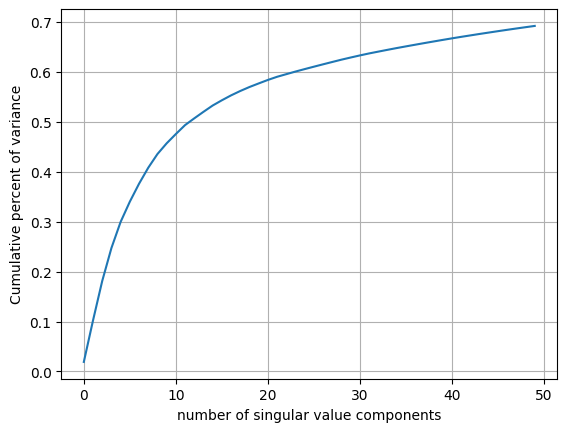

In [28]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [29]:
del svd

In [30]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

del count_df_1

In [31]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

del df_for_latent1

(97678, 50)


In [32]:
latent_df_1.reset_index().drop_duplicates().shape

(97678, 51)

In [33]:
latent_df_1

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1000894,0.479679,0.703705,-0.347103,-0.527718,0.653986,-0.486690,-0.036662,-0.083995,-0.047555,-0.044862,...,0.054260,0.190516,0.025682,-0.011648,-0.058354,0.053954,0.362089,-0.295604,-0.150441,0.200665
1000978,1.177724,-0.324887,0.813880,-0.550515,-0.759678,-0.284363,-0.160556,-0.054464,-0.050674,-0.090830,...,-0.002556,0.341302,0.000729,0.066601,-0.008678,0.103298,0.208929,-0.285964,-0.170319,0.338000
1001588,0.469582,0.767302,-0.390873,-0.540211,0.255217,0.894777,-0.774265,-0.731184,-0.122050,-0.120928,...,0.002785,-0.029138,0.009288,-0.003077,-0.001505,-0.019884,-0.050599,-0.020738,0.003819,0.016766
1001605,0.410104,0.302438,0.591097,0.386202,0.975642,-0.309749,-0.028792,-0.085603,-0.038355,-0.016856,...,0.045989,0.347607,0.073013,0.013252,-0.056804,0.067532,0.344986,-0.303446,-0.117945,0.161882
1001606,0.410104,0.302438,0.591097,0.386202,0.975642,-0.309749,-0.028792,-0.085603,-0.038355,-0.016856,...,0.045989,0.347607,0.073013,0.013252,-0.056804,0.067532,0.344986,-0.303446,-0.117945,0.161882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100063901,1.084893,-0.488910,-0.435192,0.416799,-0.198611,-0.018982,0.008710,-0.000535,0.014211,0.056581,...,0.026510,0.015767,0.000519,-0.001260,0.001977,-0.013580,-0.003404,-0.007358,-0.005218,-0.001800
100064086,0.806819,-0.571650,-0.056576,-0.247996,0.126823,0.378506,-0.004413,0.830924,-0.452358,-0.113821,...,-0.038886,0.006651,0.004557,0.019795,-0.034709,-0.005250,-0.011573,0.001454,-0.007094,-0.005805
100064193,0.883436,0.881452,-0.989845,0.528053,-0.330296,-0.223495,-0.027451,-0.075338,-0.059969,-0.088213,...,-0.088622,0.078522,-0.035064,0.069719,-0.219425,0.283441,-0.016179,-0.232340,0.071430,-0.292844
100064202,0.806819,-0.571650,-0.056576,-0.247996,0.126823,0.378506,-0.004413,0.830924,-0.452358,-0.113821,...,-0.038886,0.006651,0.004557,0.019795,-0.034709,-0.005250,-0.011573,0.001454,-0.007094,-0.005805


In [34]:
filename = f'../data/latent_dfs/latent_df_1_with_{p}%_data_{n}_svd_components.csv'
latent_df_1.to_csv(filename)

In [35]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [36]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [37]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

del df

In [38]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [39]:
df_event['rating'] = df_event['event_type'].map(dct)

In [40]:
df_event["rating"].sum()

4744779

In [41]:
# df_rating.shape

In [42]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [43]:
df_event.nunique()

event_time       1842395
event_type             3
product_id         97678
category_id          846
category_code        134
brand               3904
price              44653
user_id          1531827
user_session     2935403
rating                 3
dtype: int64

In [44]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

event_time       92677
event_type           3
product_id       97678
category_id        846
category_code      134
brand             3894
price            21307
user_id          74173
user_session     87296
rating               3
dtype: int64

In [45]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

<timed exec>:1: PerformanceWarning: The following operation may generate 7245070294 cells in the resulting pandas object.


CPU times: user 1min 3s, sys: 1min 44s, total: 2min 48s
Wall time: 3min 17s


user_id,128968633,143562268,149514167,213763705,229599188,251764632,254370989,255912498,262033761,266483328,...,595363256,595364478,595364928,595371105,595387049,595393615,595401113,595405732,595406900,595409180
product_id,,,,,,,,,,,,,,,,,,,,,
1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100063901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100064086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100064193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_rating.sum().reset_index()[0].sum()

102678.0

In [47]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    102678
dtype: int64

In [48]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    102678
dtype: int64

In [49]:
df_rating.reset_index()

user_id,product_id,128968633,143562268,149514167,213763705,229599188,251764632,254370989,255912498,262033761,...,595363256,595364478,595364928,595371105,595387049,595393615,595401113,595405732,595406900,595409180
0,1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97673,100063901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97674,100064086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97675,100064193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97676,100064202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_rating

user_id,128968633,143562268,149514167,213763705,229599188,251764632,254370989,255912498,262033761,266483328,...,595363256,595364478,595364928,595371105,595387049,595393615,595401113,595405732,595406900,595409180
product_id,,,,,,,,,,,,,,,,,,,,,
1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100063901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100064086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100064193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# df_rating.index

In [52]:
# df_rating.columns

In [53]:
# df_rating_reset_index_no_productid_col = df_rating.reset_index().iloc[:,1:]
# df_rating_reset_index_no_productid_col

In [54]:
# n_s = 75
# svd = TruncatedSVD(n_components=n_s)
# latent_df_3 = svd.fit_transform(df_rating_reset_index_no_productid_col)
# latent_df_3

In [55]:
n_s = 100
svd = TruncatedSVD(n_components=n_s)
latent_df_2 = svd.fit_transform(df_rating)

In [56]:
latent_df_2

array([[-1.83565564e-14,  4.52078955e-13, -7.98559620e-13, ...,
         4.34391231e-10, -6.52506559e-10, -3.03963611e-10],
       [-2.94178841e-14, -1.02180693e-13, -1.17315176e-14, ...,
         5.10693694e-11, -1.40222527e-10,  2.27436259e-11],
       [ 3.51644571e-14,  6.64342687e-13,  5.44389611e-13, ...,
         2.24875777e-10, -3.79916231e-11,  2.25424690e-10],
       ...,
       [-5.27010261e-15,  8.02097979e-14, -4.04846760e-14, ...,
         7.89548618e-11, -4.77114401e-11,  4.75070254e-10],
       [ 3.38606622e-12, -9.39239506e-13,  3.22526517e-11, ...,
         1.53799914e-08,  1.10171842e-08, -2.69309708e-08],
       [-1.57717775e-13,  7.40728201e-14,  4.24607606e-14, ...,
         1.26455468e-10,  3.03610555e-10,  1.06157052e-10]])

In [57]:
# latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.index)
# latent_df_2

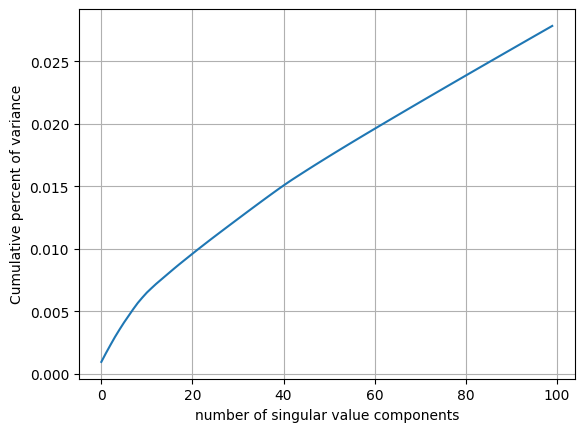

In [58]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [59]:
del svd

In [60]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1000894,-1.835656e-14,4.520790e-13,-7.985596e-13,-5.905201e-13,1.073430e-12,1.614425e-13,-1.716163e-12,-6.534994e-13,1.819376e-13,-8.999795e-13,...,-2.592643e-11,-2.201411e-10,-1.872037e-10,-2.487008e-10,-8.921736e-11,2.005085e-11,-2.275451e-10,4.343912e-10,-6.525066e-10,-3.039636e-10
1000978,-2.941788e-14,-1.021807e-13,-1.173152e-14,-2.816329e-13,1.834223e-12,3.979463e-13,1.633979e-12,-7.425283e-13,3.711580e-12,2.338082e-12,...,-4.022742e-11,-3.638857e-10,3.895402e-12,2.302426e-10,-1.132427e-10,5.862918e-11,-1.224797e-10,5.106937e-11,-1.402225e-10,2.274363e-11
1001588,3.516446e-14,6.643427e-13,5.443896e-13,5.595949e-13,8.009927e-13,-2.208433e-13,-8.459085e-14,3.144015e-13,9.922731e-13,-1.052064e-11,...,3.107847e-10,3.567679e-11,-4.318511e-10,-3.367824e-10,5.466734e-11,-1.559944e-10,1.840067e-10,2.248758e-10,-3.799162e-11,2.254247e-10
1001605,4.855821e-14,-3.268435e-13,-4.457225e-13,2.409434e-13,7.628716e-13,3.947373e-13,6.325431e-13,-1.888941e-12,3.595318e-12,-3.991449e-12,...,-9.184417e-11,2.393336e-10,6.375184e-12,2.030610e-10,-4.624885e-10,-1.592591e-10,-2.892722e-10,-3.349816e-10,3.388150e-10,-3.307759e-10
1001606,1.424618e-14,-8.109685e-14,3.457390e-13,-8.807927e-13,9.649459e-14,2.099010e-12,8.082827e-13,-2.844927e-13,2.039062e-12,5.939513e-12,...,-3.097525e-10,4.939785e-11,-4.056259e-10,-3.369652e-10,-9.648606e-12,-3.077545e-11,2.516165e-10,5.570320e-10,-3.096536e-10,2.338247e-10


In [61]:
latent_df_2.shape

(97678, 100)

In [62]:
filename_2 = f'../data/latent_dfs/latent_df_2_with_{p}%_data_{n_s}_svd_components.csv'
latent_df_2.to_csv(filename_2)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [ ]:
product_id=5100337

In [ ]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [ ]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [ ]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [ ]:
weight_features = 0.8

In [ ]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [ ]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

In [ ]:
recommendation_combined.head()

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    
    return feat_idx
    
#     for i in feat_idx:
#         meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
#         lst = []
#         lst.append(meta_text)
#         return lst

In [ ]:
indexes = top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
len(indexes)

In [ ]:
X_meta[X_meta.index.isin(indexes)]['metadata']

In [ ]:
# X_meta.head()

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    return pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices})

In [ ]:
# top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
# new_df = top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
# new_df.drop_duplicates('meta_text').iloc[:10,:]

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    new_df = pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices}).drop_duplicates('meta_text').iloc[:n,:]
    return new_df.reset_index().drop(columns='index')

In [ ]:
# top_n_products(recommendation_combined, X_meta, ranking='features', n=10)